This notebook uses cvxpy library (it has been installed on urbana package, so it should be updated in order to use the entire program)

In [1]:
%load_ext lab_black

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys

sys.path.append(
    "/Users/mateo/Documents/Máster Big Data/TFM/codes/urbana-barcelona-master/src"
)

In [4]:
import os
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns

from urbana.models.plot_predictions import PredictedAccuracy
from urbana.constants import DIR_REPO, DIR_DATA

In [5]:
# papermill parameters cell
# https://papermill.readthedocs.io/en/latest/usage-parameterize.html

YEAR = 2023  # ALLOWED_YEARS = [2017, 2018, 2023]
MONTH = 12

OUTPUT_WARNINGS = False
SAVE_FIGS = False
FIT_INTERCEPT = True

VARIABLE_TO_PREDICT = "Airbnb_Number"

# Number of selected variables in these categories
K_EDUCATION = 1
K_AGE = 2
K_NATIONALITY = 2
K_RENT = 1
K_POI = 10

# Warnings
if not OUTPUT_WARNINGS:
    import warnings

    warnings.filterwarnings("ignore")

# Parameter check
ALLOWED_YEARS = [2017, 2018, 2023]

if YEAR not in ALLOWED_YEARS:
    raise Exception("Please select a year within: {}".format(ALLOWED_YEARS))

if YEAR == 2018 and MONTH == 3:
    raise Exception(
        "Month 3 (March) is not available for 2018. Please choose a different month."
    )

# Create folders to store the data
DIR_VAR = DIR_DATA / "processed/{}".format(VARIABLE_TO_PREDICT)
DIR_MONTH = DIR_VAR / "{}_{:02d}".format(YEAR, MONTH)
DIR_GWSVR = DIR_MONTH / "06_gwsvr"

if SAVE_FIGS:
    folder_list = [
        DIR_GWSVR,
        DIR_GWSVR / "coefficients",
    ]
    for folder in folder_list:
        if not os.path.exists(folder):
            os.makedirs(folder)

PATH_TO_FILE = DIR_DATA / "interim/sections_{}_{:02d}.csv".format(YEAR, MONTH)
if os.path.isfile(PATH_TO_FILE) is False:
    raise Exception(
        'Please run first the notebook "00acquisition.ipynb" with the same date and "SAVE_DATA" set to True'
    )

PATH_TO_FILE = DIR_MONTH / "01_linear/coefficients.csv"
if os.path.isfile(PATH_TO_FILE) is False:
    raise Exception(
        'Please run first the notebook "01linear.ipynb" with the same date and "SAVE_MODEL" set to True'
    )

# Data Import

In [6]:
sect = pd.read_csv(DIR_DATA / "interim/sections_{}_{:02d}.csv".format(YEAR, MONTH))
sect.set_index("Tag", inplace=True)
sect.drop(
    [
        "N_district",
        "N_neighbourhood",
        "N_section",
        "Airbnb_Price",
        "Airbnb_Price_Person",
        "Airbnb_Location_Score",
        "Percentage_Age_25_39",
    ],
    axis=1,
    inplace=True,
)

X = sect.drop(VARIABLE_TO_PREDICT, axis=1)
y = np.array(sect[VARIABLE_TO_PREDICT]).reshape((-1, 1))

geo_info = gpd.read_file(DIR_DATA / "interim/sections_geo.json")
geo_info.set_index("Tag", inplace=True)

geo_coefs = geo_info.copy()
geo_tvals = geo_info.copy()
geo_nans = geo_info.copy()

geo_info[VARIABLE_TO_PREDICT] = sect[VARIABLE_TO_PREDICT]

coords = np.column_stack(
    [geo_info["geometry"].centroid.x, geo_info["geometry"].centroid.y]
)

geo_info["centroid"] = geo_info["geometry"].centroid

# 1st model: All features

GWSVR 

For each section $j$: 

$$
\min_{\mathbf{w}, b, \xi, \xi^*} \frac{1}{2} \|\mathbf{w}\|^2 + \sum_{i=1}^n (\xi_i + \xi_i^*) \rho_{ij}
$$

subject to:

$$
\begin{align*}
y_i - \mathbf{w}^T \mathbf{x}_i - b &\leq \epsilon + \xi_i \\
\mathbf{w}^T \mathbf{x}_i + b - y_i &\leq \epsilon + \xi_i^* \\
\xi_i, \xi_i^* &\geq 0
\end{align*}
$$


In [7]:
# import cvxpy as cp
# from scipy.spatial.distance import cdist
# from sklearn.metrics import mean_squared_error
# from joblib import Parallel, delayed

# centroids = geo_info.centroid
# centroids = np.array([[point.x, point.y] for point in geo_info["centroid"]])

# distances = cdist(centroids, centroids, "euclidean")

# print("distances.shape: ", distances.shape)


# # Function to compute Gaussian weights
# def compute_gaussian_weights(distances, bandwidth):
#     weights = np.exp(-0.5 * (distances / bandwidth) ** 2)
#     return weights.reshape(-1, 1)


# def fit_svr_with_weights(X_train, y_train, weights, C=1024, epsilon=0.1):
#     w = cp.Variable((X_train.shape[1], 1))
#     b = cp.Variable()
#     xi_pos = cp.Variable((X_train.shape[0], 1))
#     xi_neg = cp.Variable((X_train.shape[0], 1))

#     objective = cp.Minimize(
#         0.5 * cp.sum_squares(w) + cp.sum(cp.multiply(weights, xi_pos + xi_neg))
#     )

#     constraints = [
#         y_train.reshape(-1, 1) - cp.matmul(X_train, w) - b <= epsilon + xi_pos,
#         cp.matmul(X_train, w) + b - y_train.reshape(-1, 1) <= epsilon + xi_neg,
#         xi_pos >= 0,
#         xi_neg >= 0,
#     ]
#     problem = cp.Problem(objective, constraints)
#     problem.solve()

#     return w.value, b.value


# def gwsvr(X_train, y_train, bw):

#     all_w, all_b, y_pred = [], [], []

#     for j in range(len(centroids)):

#         # Compute weights
#         weights = compute_gaussian_weights(distances, bw)

#         # X_section = X_train[j].reshape(1, X_train.shape[1])
#         # y_section = y_train[j]

#         # Fit SVR with current weights
#         w, b = fit_svr_with_weights(X_train, y_train, weights)

#         # Train predictions and evaluate
#         y_j = (np.matmul(X_train[j], w) + b).item()
#         y_train_j = y_train[j]

#         # error = (y_j - y_train_j) / y_train_j
#         # print(f"Location {j}: Bandwidth = {bw}, error = {error}")

#         all_w.append(w)
#         all_b.append(b)
#         y_pred.append(y_j)

#     return all_w, all_b, y_pred, y_train

In [8]:
import cvxpy as cp
from scipy.spatial.distance import cdist
from sklearn.metrics import mean_squared_error
from joblib import Parallel, delayed

centroids = geo_info.centroid
centroids = np.array([[point.x, point.y] for point in geo_info["centroid"]])

distances = cdist(centroids, centroids, "euclidean")


# Function to compute Gaussian weights
def compute_gaussian_weights(distances, bandwidth, j):
    weights = np.exp(-0.5 * (distances[j, :] / bandwidth) ** 2)
    return weights.reshape(-1, 1)


def fit_svr_with_weights(X_train, y_train, weights, C=1024, epsilon=0.1):
    w = cp.Variable((X_train.shape[1], 1))
    b = cp.Variable()
    xi_pos = cp.Variable((X_train.shape[0], 1))
    xi_neg = cp.Variable((X_train.shape[0], 1))

    objective = cp.Minimize(
        0.5 * cp.sum_squares(w) + cp.sum(cp.multiply(weights, xi_pos + xi_neg))
    )

    constraints = [
        y_train.reshape(-1, 1) - cp.matmul(X_train, w) - b <= epsilon + xi_pos,
        cp.matmul(X_train, w) + b - y_train.reshape(-1, 1) <= epsilon + xi_neg,
        xi_pos >= 0,
        xi_neg >= 0,
    ]
    problem = cp.Problem(objective, constraints)
    problem.solve()

    return w.value, b.value


# def gwsvr(X_train, y_train, bw):

#     all_w, all_b, y_pred = [], [], []

#     for j in range(len(centroids)):

#         # Compute weights
#         weights = compute_gaussian_weights(distances, bw, j)

#         # X_section = X_train[j].reshape(1, X_train.shape[1])
#         # y_section = y_train[j]

#         # Fit SVR with current weights
#         w, b = fit_svr_with_weights(X_train, y_train, weights)

#         # Train predictions and evaluate
#         y_j = (np.matmul(X_train[j], w) + b).item()
#         y_train_j = y_train[j]

#         # error = (y_j - y_train_j) / y_train_j
#         # print(f"Location {j}: Bandwidth = {bw}, error = {error}")

#         all_w.append(w)
#         all_b.append(b)
#         y_pred.append(y_j)

#     return all_w, all_b, y_pred, y_train


def gwsvr(X_train, y_train, bw):

    def svr_section(j):
        # Compute weights
        weights = compute_gaussian_weights(distances, bw, j)

        # Fit SVR with current weights
        w, b = fit_svr_with_weights(X_train, y_train, weights)

        # Train predictions and evaluate
        y_j = (np.matmul(X_train[j], w) + b).item()
        y_train_j = y_train[j]

        return w, b, y_j, y_train_j

    results = Parallel(n_jobs=-1)(delayed(svr_section)(j) for j in range(len(X_train)))

    all_w, all_b, y_pred, y_train = zip(*results)

    return list(all_w), list(all_b), y_pred, y_train

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

from pysal.model import mgwr

# Preprocessing
X_train = X.to_numpy()
y_train = y

imputer = KNNImputer()
X_train = imputer.fit_transform(X_train)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Bandwidth Selection - One for all
y_resh = y_train.reshape((-1, 1))
gwr_chosen_selector = mgwr.sel_bw.Sel_BW(
    coords, y_resh, X_train, fixed=False, spherical=True, multi=False
)
gwr_bw = gwr_chosen_selector.search()
print("Bandwith with GWR - AIC: " + str(int(gwr_bw)))

# Specific bw selection
# mgwr_chosen_selector = mgwr.sel_bw.Sel_BW(
#     coords, y_resh, X_train, fixed=False, spherical=True, multi=True
# )
# mgwr_bw = mgwr_chosen_selector.search()
# print("Bandwith with MGWR - AIC: " + str(int(mgwr_bw)))

Bandwith with GWR - AIC: 779


## Model Evaluation

In [10]:
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score


def metrics(y_truth, y_pred, name, reduced=False):

    mse = mean_squared_error(y_truth, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_truth, y_pred)
    n, p = len(y), X_train.shape[1]
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    evs = explained_variance_score(y_truth, y_pred)
    aic = len(y) * np.log(mse) + 2 * p

    gwsvr_metrics = {
        "MSE": [mse],
        "RMSE": [rmse],
        "R^2": [r2],
        "Adj R^2": [adjusted_r2],
        "EVs": [evs],
        "AIC": [aic],
    }
    df_gwsvr_metrics = pd.DataFrame(gwsvr_metrics, index=[name])

    filename = "metrics.csv"
    if reduced == True:
        filename = "metrics_red.csv"

    df_metrics = pd.read_csv(filename, index_col=0)
    df_metrics = pd.concat([df_metrics, df_gwsvr_metrics])
    df_metrics.to_csv(filename, index=True)

    return df_metrics

In [11]:
bw = int(gwr_bw)
all_w, all_b, y_pred, y_truth = gwsvr(X_train, y_train, bw)

df_metrics = metrics(y_truth, y_pred, "GWSVR", reduced=False)
df_metrics

,MSE,RMSE,R^2,Adj R^2,EVs,AIC
Linear Regression,119.908203,10.950260,0.818644,0.803146,0.818644,5280.223871
GWR,128.109551,11.318549,0.806239,0.789682,0.808532,1529.338979
MESF-Queen,115.669618,10.754981,0.825054,0.808153,0.825054,5261.788195
MESF-KNN,116.309755,10.784700,0.824086,0.807091,0.824086,5267.682404
MESF-Gabriel,114.353896,10.693638,0.827044,0.810335,0.827044,5249.570252
SVR,0.914437,0.956262,0.998617,0.998499,0.998676,72.470973
GWSVR,158.500932,12.589715,0.760273,0.739788,0.762626,5578.232186


#### Spatial Autocorrelation handling

##### Moran's I on residuals 

In [12]:
from libpysal.weights import Queen
from esda.moran import Moran


def calculate_morans_i(residuals, geo_info):
    w = Queen.from_dataframe(geo_info)
    w.transform = "R"
    moran = Moran(residuals, w)
    return moran.I, moran.p_sim


def metrics_autocorr(y, y_pred, name, reduced=False):

    residuals = y.flatten() - list(y_pred)
    moran = calculate_morans_i(residuals, geo_info)

    autocorr_metrics = {
        "Moran's I": [moran[0]],
        # "Mean MSE": [mean_mse]
    }
    df_autocorr_gwsvr_metrics = pd.DataFrame(autocorr_metrics, index=[name])

    filename = "metrics_autocorr.csv"
    if reduced == True:
        filename = "metrics_autocorr_red.csv"

    df_autocorr_metrics = pd.read_csv(filename, index_col=0)
    df_autocorr_metrics = pd.concat([df_autocorr_metrics, df_autocorr_gwsvr_metrics])
    df_autocorr_metrics.to_csv(filename, index=True)
    df_autocorr_metrics

    return df_autocorr_metrics


df_metrics_autocorr = metrics_autocorr(y, y_pred, "GWSVR", reduced=False)
df_metrics_autocorr

,Moran's I,Mean MSE
Linear Regression,0.133607,181.599291
GWR,0.091858,192.927322
MESF-Queen,0.110892,275.651324
MESF-KNN,0.093927,215.337178
MESF-Gabriel,0.050416,253.331825
SVR,0.098604,280.698096
GWSVR,0.284684,NaN


In [13]:
df_predictions_gwsvr = pd.DataFrame({"GWSVR": y_pred})
df_predictions = pd.read_csv("predictions.csv", index_col=0)
df_predictions = pd.concat([df_predictions, df_predictions_gwsvr], axis=1)
df_predictions.to_csv("predictions.csv")
df_predictions

,y,Linear Regression,GWR,MESF-Q,MESF-K,MESF-G,SVR,GWSVR
0,76,80.116570,74.0,78.788502,77.417599,79.209439,75.000357,74.028969
1,61,64.307523,44.0,61.744177,61.695660,62.114164,60.000187,66.550022
2,50,37.518577,27.0,39.172746,37.617358,41.064195,49.000139,35.924829
3,82,76.720780,68.0,75.822136,76.570385,77.382745,81.000239,65.378482
4,108,95.588241,58.0,96.024349,97.085118,94.205170,107.000223,77.194040
...,...,...,...,...,...,...,...,...
1063,1,-2.148651,2.0,-6.023376,-1.865126,-5.117239,0.528833,0.818385
1064,6,2.940087,4.0,3.446457,2.601677,2.442538,4.999644,6.051567
1065,7,-4.402845,4.0,-7.901989,-8.076774,-6.695285,8.000002,3.329263
1066,4,5.976093,4.0,2.970398,1.929307,3.699902,4.999759,6.705815


# 2nd model: linear model variables

In [14]:
linear_coefs = pd.read_csv(DIR_MONTH / "01_linear/coefficients.csv", index_col=0)
best_model_linear = linear_coefs.drop(["Intercept"], axis=1).columns

X_chosen = sect[best_model_linear]

print(best_model_linear)

Index(['Distance_Center', 'POI_Restaurants_Hotels', 'Nationality_Italy',
       'Nationality_UK', 'Percentage_Age_65_Plus', 'Percentage_Age_0_14'],
      dtype='object')


## Model Evaluation

In [15]:
bw = int(gwr_bw)
all_w_red, all_b_red, y_pred_red, y_truth_red = gwsvr(np.array(X_chosen), y_train, bw)

df_metrics_red = metrics(y_truth_red, y_pred_red, "GWSVR", reduced=True)
df_metrics_red

,MSE,RMSE,R^2,Adj R^2,EVs,AIC
Linear Regression,160.004466,12.649287,0.757999,0.753377,0.762458,5460.315447
GWR,92.873596,9.637095,0.859532,0.858738,0.862931,1481.899846
MESF-Queen,151.535571,12.309979,0.770808,0.748666,0.770808,5550.236174
MESF-KNN,149.073928,12.209583,0.774531,0.752749,0.774531,5532.744424
MESF-Gabriel,147.121775,12.129377,0.777484,0.755987,0.777484,5518.666371
SVR,37.509157,6.124472,0.943269,0.938421,0.944206,4039.056882
GWSVR,221.596309,14.886111,0.664844,0.636204,0.671020,5936.115593


#### Spatial Autocorrelation handling

##### Moran's I on residuals 

In [16]:
df_metrics_autocorr_red = metrics_autocorr(y, y_pred_red, "GWSVR", reduced=True)
df_metrics_autocorr_red

,Moran's I,Mean MSE
Linear Regression,0.214738,178.444837
GWR,0.101605,120.867957
MESF-Queen,0.224924,252.064666
MESF-KNN,0.176038,236.256972
MESF-Gabriel,0.151428,255.266136
SVR,0.122126,295.315257
GWSVR,0.505956,NaN


In [17]:
df_predictions_gwsvr = pd.DataFrame({"GWSVR": y_pred_red})
df_predictions_red = pd.read_csv("predictions_red.csv", index_col=0)
df_predictions_red = pd.concat([df_predictions, df_predictions_gwsvr], axis=1)
df_predictions_red.to_csv("predictions_red.csv")
df_predictions_red

,y,Linear Regression,GWR,MESF-Q,MESF-K,MESF-G,SVR,GWSVR,GWSVR
0,76,80.116570,74.0,78.788502,77.417599,79.209439,75.000357,74.028969,43.954807
1,61,64.307523,44.0,61.744177,61.695660,62.114164,60.000187,66.550022,29.893908
2,50,37.518577,27.0,39.172746,37.617358,41.064195,49.000139,35.924829,30.300741
3,82,76.720780,68.0,75.822136,76.570385,77.382745,81.000239,65.378482,48.643988
4,108,95.588241,58.0,96.024349,97.085118,94.205170,107.000223,77.194040,55.831853
...,...,...,...,...,...,...,...,...,...
1063,1,-2.148651,2.0,-6.023376,-1.865126,-5.117239,0.528833,0.818385,-1.553915
1064,6,2.940087,4.0,3.446457,2.601677,2.442538,4.999644,6.051567,9.547738
1065,7,-4.402845,4.0,-7.901989,-8.076774,-6.695285,8.000002,3.329263,6.076590
1066,4,5.976093,4.0,2.970398,1.929307,3.699902,4.999759,6.705815,7.153998


## Coefficients - support vectors

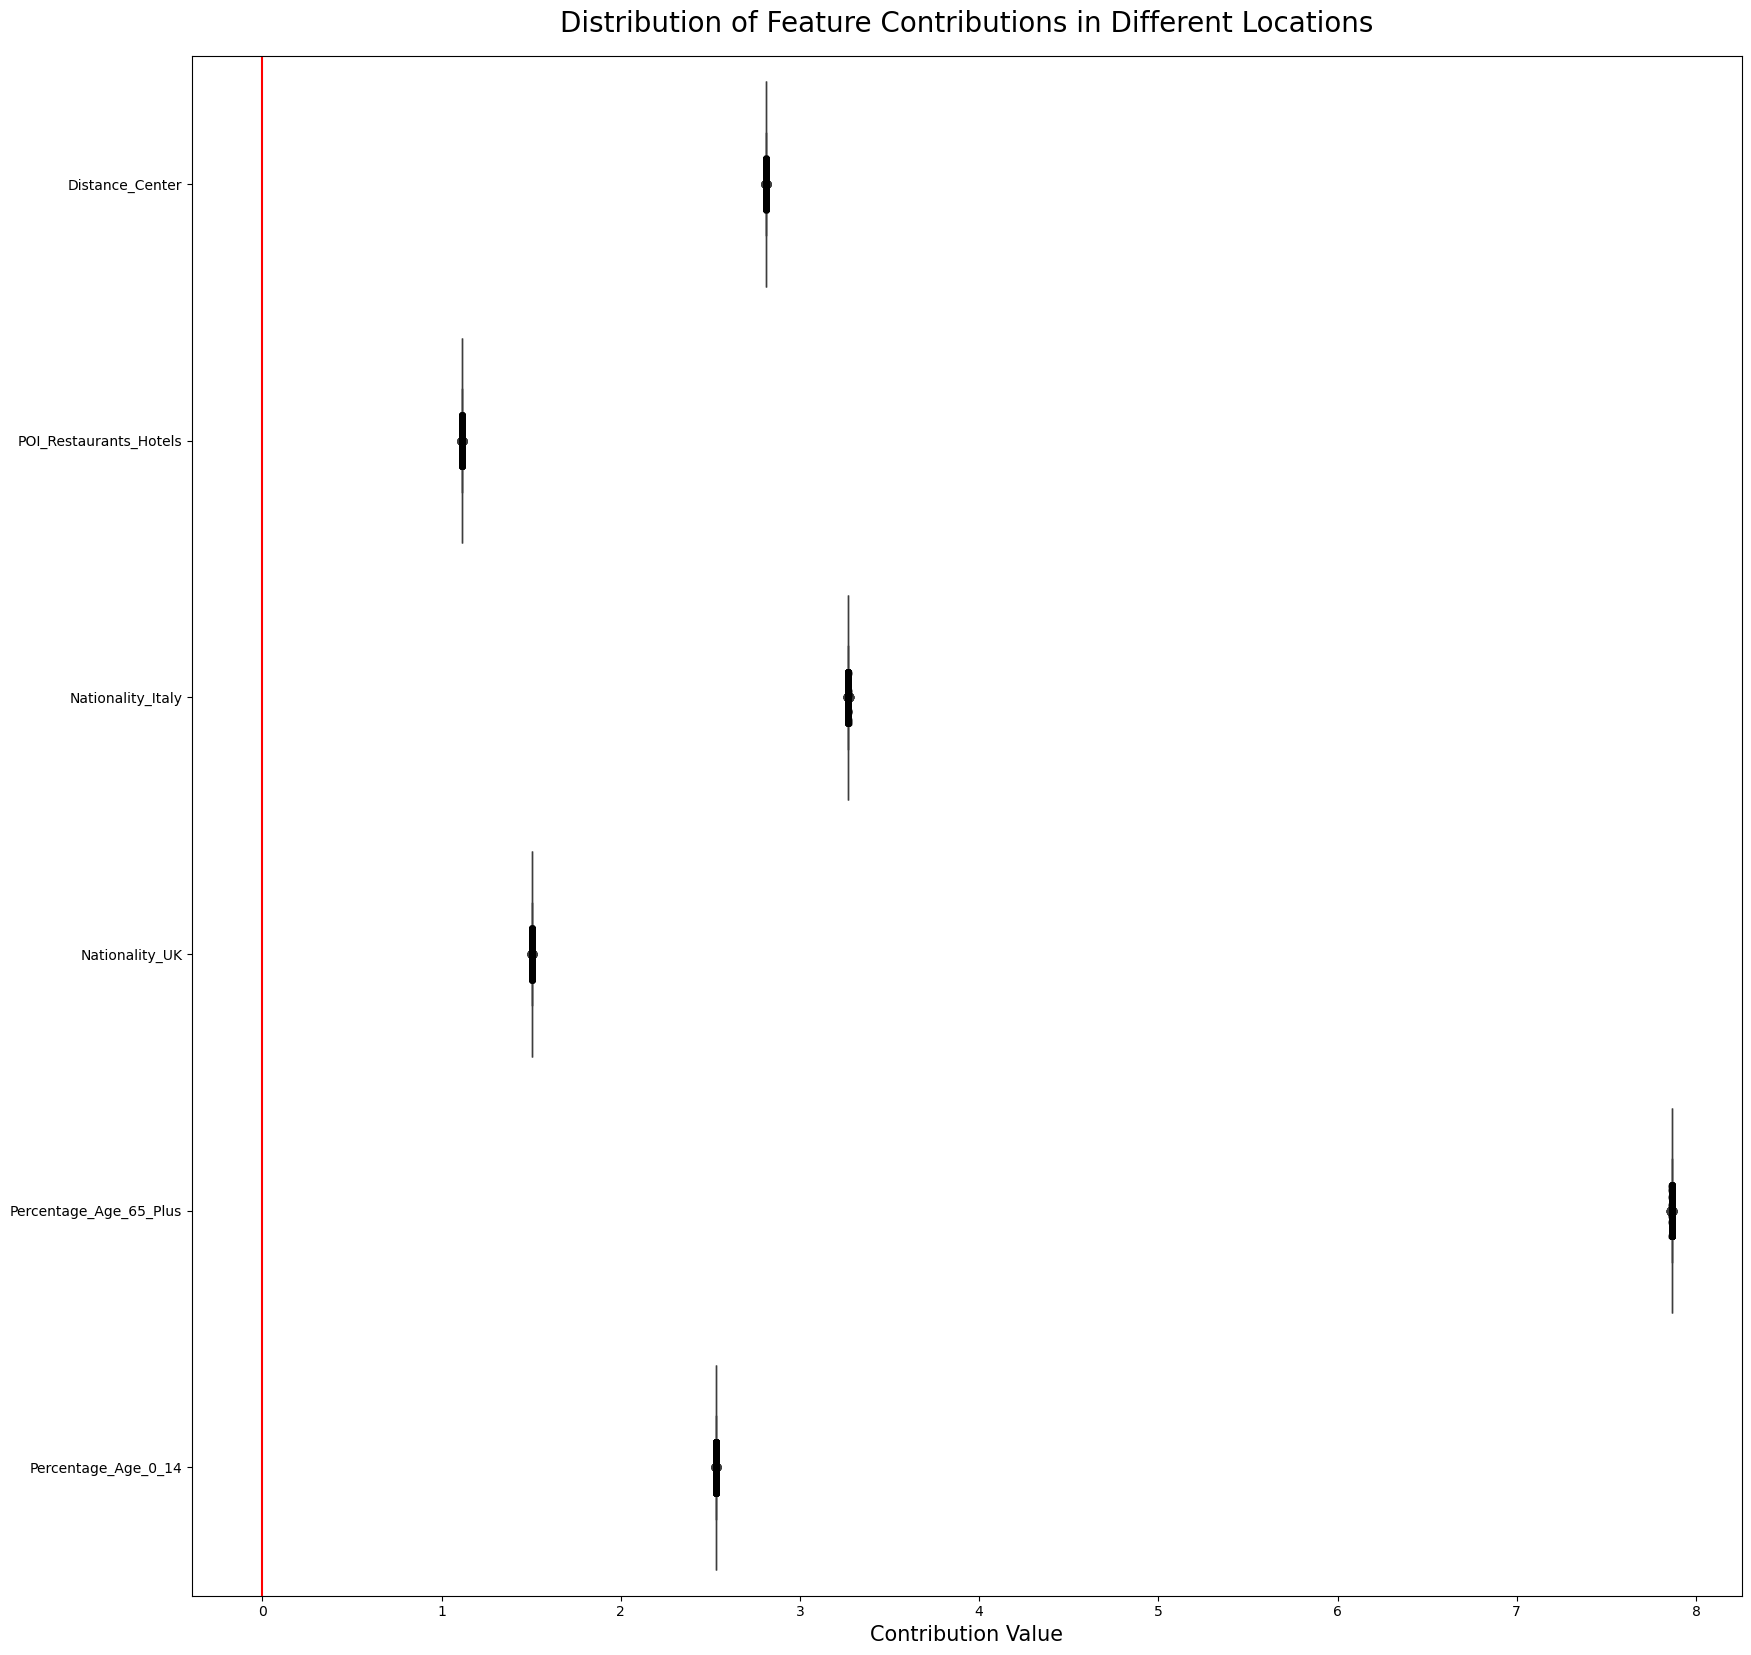

In [50]:
feature_names = X_chosen.columns.tolist()

mean_contributions_list = [np.abs(w).flatten() for w in all_w_red]
contributions_df = pd.DataFrame(mean_contributions_list, columns=feature_names)

fig, ax = plt.subplots(figsize=(20, 20))

sns.stripplot(
    ax=ax,
    data=contributions_df,
    orient="h",
    color="k",
    alpha=0.5,
)
sns.boxplot(
    ax=ax,
    data=contributions_df,
    orient="h",
    color="cyan",
    saturation=0.5,
)

plt.axvline(x=0, color="red")

ax.set_title(
    "Distribution of Feature Contributions in Different Locations",
    fontsize=20,
    y=1.01,
)
ax.set_xlabel("Contribution Value", fontsize=15)

plt.show()